In [153]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from Regressor import RegressorWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import logging
import re
import sqlite3
#Définition de constantes
AXE_COLONNES = 1

## Sources

| Sources_données_originales | Date_de_mise_à_jour |
| ---------------------------|---------------------|
| https://www.insee.fr/fr/statistiques/serie/010760415#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760376#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/7076724#onglet-1 | 11/04/23 |
| https://www.insee.fr/fr/statistiques/7076722 | 07/04/23 |
| https://www.insee.fr/fr/statistiques/serie/010760261#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760364#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759840#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759801#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760261 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759955 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760300 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759801 | 26/01/23 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/ | 14/04/2023 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-23-avril-et-7-mai-2017-resultats-du-1er-tour/ | 24/04/2017 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-2012-resultats-572124/ | 06/01/2014 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-2007-resultats-572120/ | 06/01/2014 |
| https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-et-departementale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/ | 09/03/2023 |

# Traitement des données sur l'emploi
## Obtention des données

In [154]:
sns.set(rc={'figure.figsize':(20,8.27)})

In [155]:
def separer_numero_departement(valeur):
    valeur_a_comparer = valeur.strip().lower()
    if valeur_a_comparer == "loire atlantique":
       return 44
    elif valeur_a_comparer == "alpes-maritimes":
       return 6

In [156]:
def afficher_noms_colonnes_avec_valeurs_manquantes(dataframe):
  column_labels = list(dataframe.columns)
  for column_label in column_labels:
    if dataframe[column_label].hasnans:
      print(column_label)

In [157]:
sheet_names = ['Emploi LA', 'Emploi Indus LA', 'Tertiaire marchand LA', 'Tertiaire non march LA', 'Chom LA', 'Emploi AM', 'Emploi Indus AM', 'Tertiaire march AM', 'Tertiaire non march AM OK', 'Chom AM']
dict_donnees_insee = pd.read_excel("./data/donnees_insee.xlsx", sheet_name=sheet_names, skiprows=6)
dict_donnees_insee['Tertiaire non march AM OK'] = dict_donnees_insee['Tertiaire non march AM OK'].drop(33, axis=0)
print(len(dict_donnees_insee))
for item in dict_donnees_insee.items():
   dataframe = dict_donnees_insee[item[0]]
   dataframe = dataframe.dropna(axis=0, how="all")
   dict_donnees_insee[item[0]] = dataframe
   #print(item[0], str(dict_donnees_insee[item[0]].shape))
dataframes = dict_donnees_insee.values()
dataset_insee = pd.concat(dataframes, axis=0,keys=sheet_names).reset_index(level=1,drop=True)
dataset_insee.insert(0,"N°_Departement",dataset_insee["Zone_geographique"].apply(separer_numero_departement))
dataset_insee = dataset_insee.drop("Zone_geographique", axis=AXE_COLONNES)
dataset_insee['2002T4'] = dataset_insee['2002T4'].astype(np.int64)
display(dataset_insee)

10


,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi LA,44,513549.0,519946.50,521034.5,522314.00,518667,519755.0,521034.5,522122.5,523019.0,...,608047.000000,608497.0,614328.000000,621391.000000,626772.000000,633914.0,637679.000000,640581.000000,643603.000000,645104.0
Emploi Indus LA,44,87440.0,87769.75,88099.5,88429.25,86121,86567.0,87013.0,87459.0,84337.0,...,85414.000000,85526.0,84912.500000,84299.000000,83685.500000,87980.0,87980.000000,87980.000000,87980.000000,NaN
Tertiaire marchand LA,44,290834.0,288973.00,288577.0,288965.00,287697,285539.0,286943.0,284718.0,283144.0,...,257727.000000,257244.0,257796.000000,258723.000000,259970.000000,261487.0,262210.000000,263290.000000,265222.000000,266202.0
Tertiaire non march LA,44,145778.0,146213.50,146649.0,147084.50,147520,148151.5,148783.0,149414.5,150046.0,...,185481.500000,185826.0,186265.500000,186705.000000,187144.500000,187584.0,187742.213883,187742.213883,187742.213883,188216.0
Chom LA,44,6.5,6.40,6.4,6.40,6,6.8,6.9,6.8,7.1,...,7.800000,6.9,6.900000,6.600000,6.600000,6.1,5.900000,6.000000,6.000000,5.8
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.000000,434185.0
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.200000,33505.0
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.000000,194307.0
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,NaN,NaN,NaN,NaN
Chom AM,6,10.2,10.00,9.8,9.60,9,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.300000,8.200000,8.200000,8.0


## Analyse des données statistiques sur l'emploi (moyenne, médiane, écart-type...)

In [158]:
# Suppression de la colonne N°Département, qui est inutile pour le calcul de la moyenne
donnees_insee_sans_numero_dep = dataset_insee.drop("N°_Departement", axis=AXE_COLONNES)
# Isolation des lignes concernant le chomâge, en effet le taux de chomage étant un pourcentage, la moyenne à utiliser est la moyenne harmonique et non la moyenne arithmétique
noms_lignes_chomage = ["Chom LA","Chom AM"]
lignes_chomage = donnees_insee_sans_numero_dep.loc[noms_lignes_chomage]
#Isolation des lignes concernant l'emploi
lignes_emploi = donnees_insee_sans_numero_dep.drop(noms_lignes_chomage, axis ='index')
#Calcul des grandeurs statistiques sur les deux jeux de données
statistiques_emploi_par_lignes = lignes_emploi.apply(pd.DataFrame.describe, axis=1)
display(lignes_chomage)
display(lignes_emploi)

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Chom LA,6.5,6.4,6.4,6.4,6,6.8,6.9,6.8,7.1,7.3,...,7.8,6.9,6.9,6.6,6.6,6.1,5.9,6.0,6.0,5.8
Chom AM,10.2,10.0,9.8,9.6,9,9.9,10.0,9.8,10.0,10.1,...,10.1,9.1,9.3,9.0,8.9,8.4,8.3,8.2,8.2,8.0


,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi LA,513549.0,519946.50,521034.5,522314.00,518667,519755.0,521034.5,522122.5,523019.0,525160.0,...,608047.000000,608497.0,614328.000000,621391.000000,626772.000000,633914.0,637679.000000,640581.000000,643603.000000,645104.0
Emploi Indus LA,87440.0,87769.75,88099.5,88429.25,86121,86567.0,87013.0,87459.0,84337.0,84749.5,...,85414.000000,85526.0,84912.500000,84299.000000,83685.500000,87980.0,87980.000000,87980.000000,87980.000000,NaN
Tertiaire marchand LA,290834.0,288973.00,288577.0,288965.00,287697,285539.0,286943.0,284718.0,283144.0,281494.0,...,257727.000000,257244.0,257796.000000,258723.000000,259970.000000,261487.0,262210.000000,263290.000000,265222.000000,266202.0
Tertiaire non march LA,145778.0,146213.50,146649.0,147084.50,147520,148151.5,148783.0,149414.5,150046.0,150618.0,...,185481.500000,185826.0,186265.500000,186705.000000,187144.500000,187584.0,187742.213883,187742.213883,187742.213883,188216.0
Emploi AM,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,433880.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.000000,434185.0
Emploi Indus AM,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,34297.4,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.200000,33505.0
Tertiaire march AM,151712.4,153507.00,153934.4,154494.00,154861,155220.0,156114.0,156405.2,156726.6,157989.0,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.000000,194307.0
Tertiaire non march AM OK,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,128730.5,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,NaN,NaN,NaN,NaN


## Traîtement des données manquantes sur l'emploi

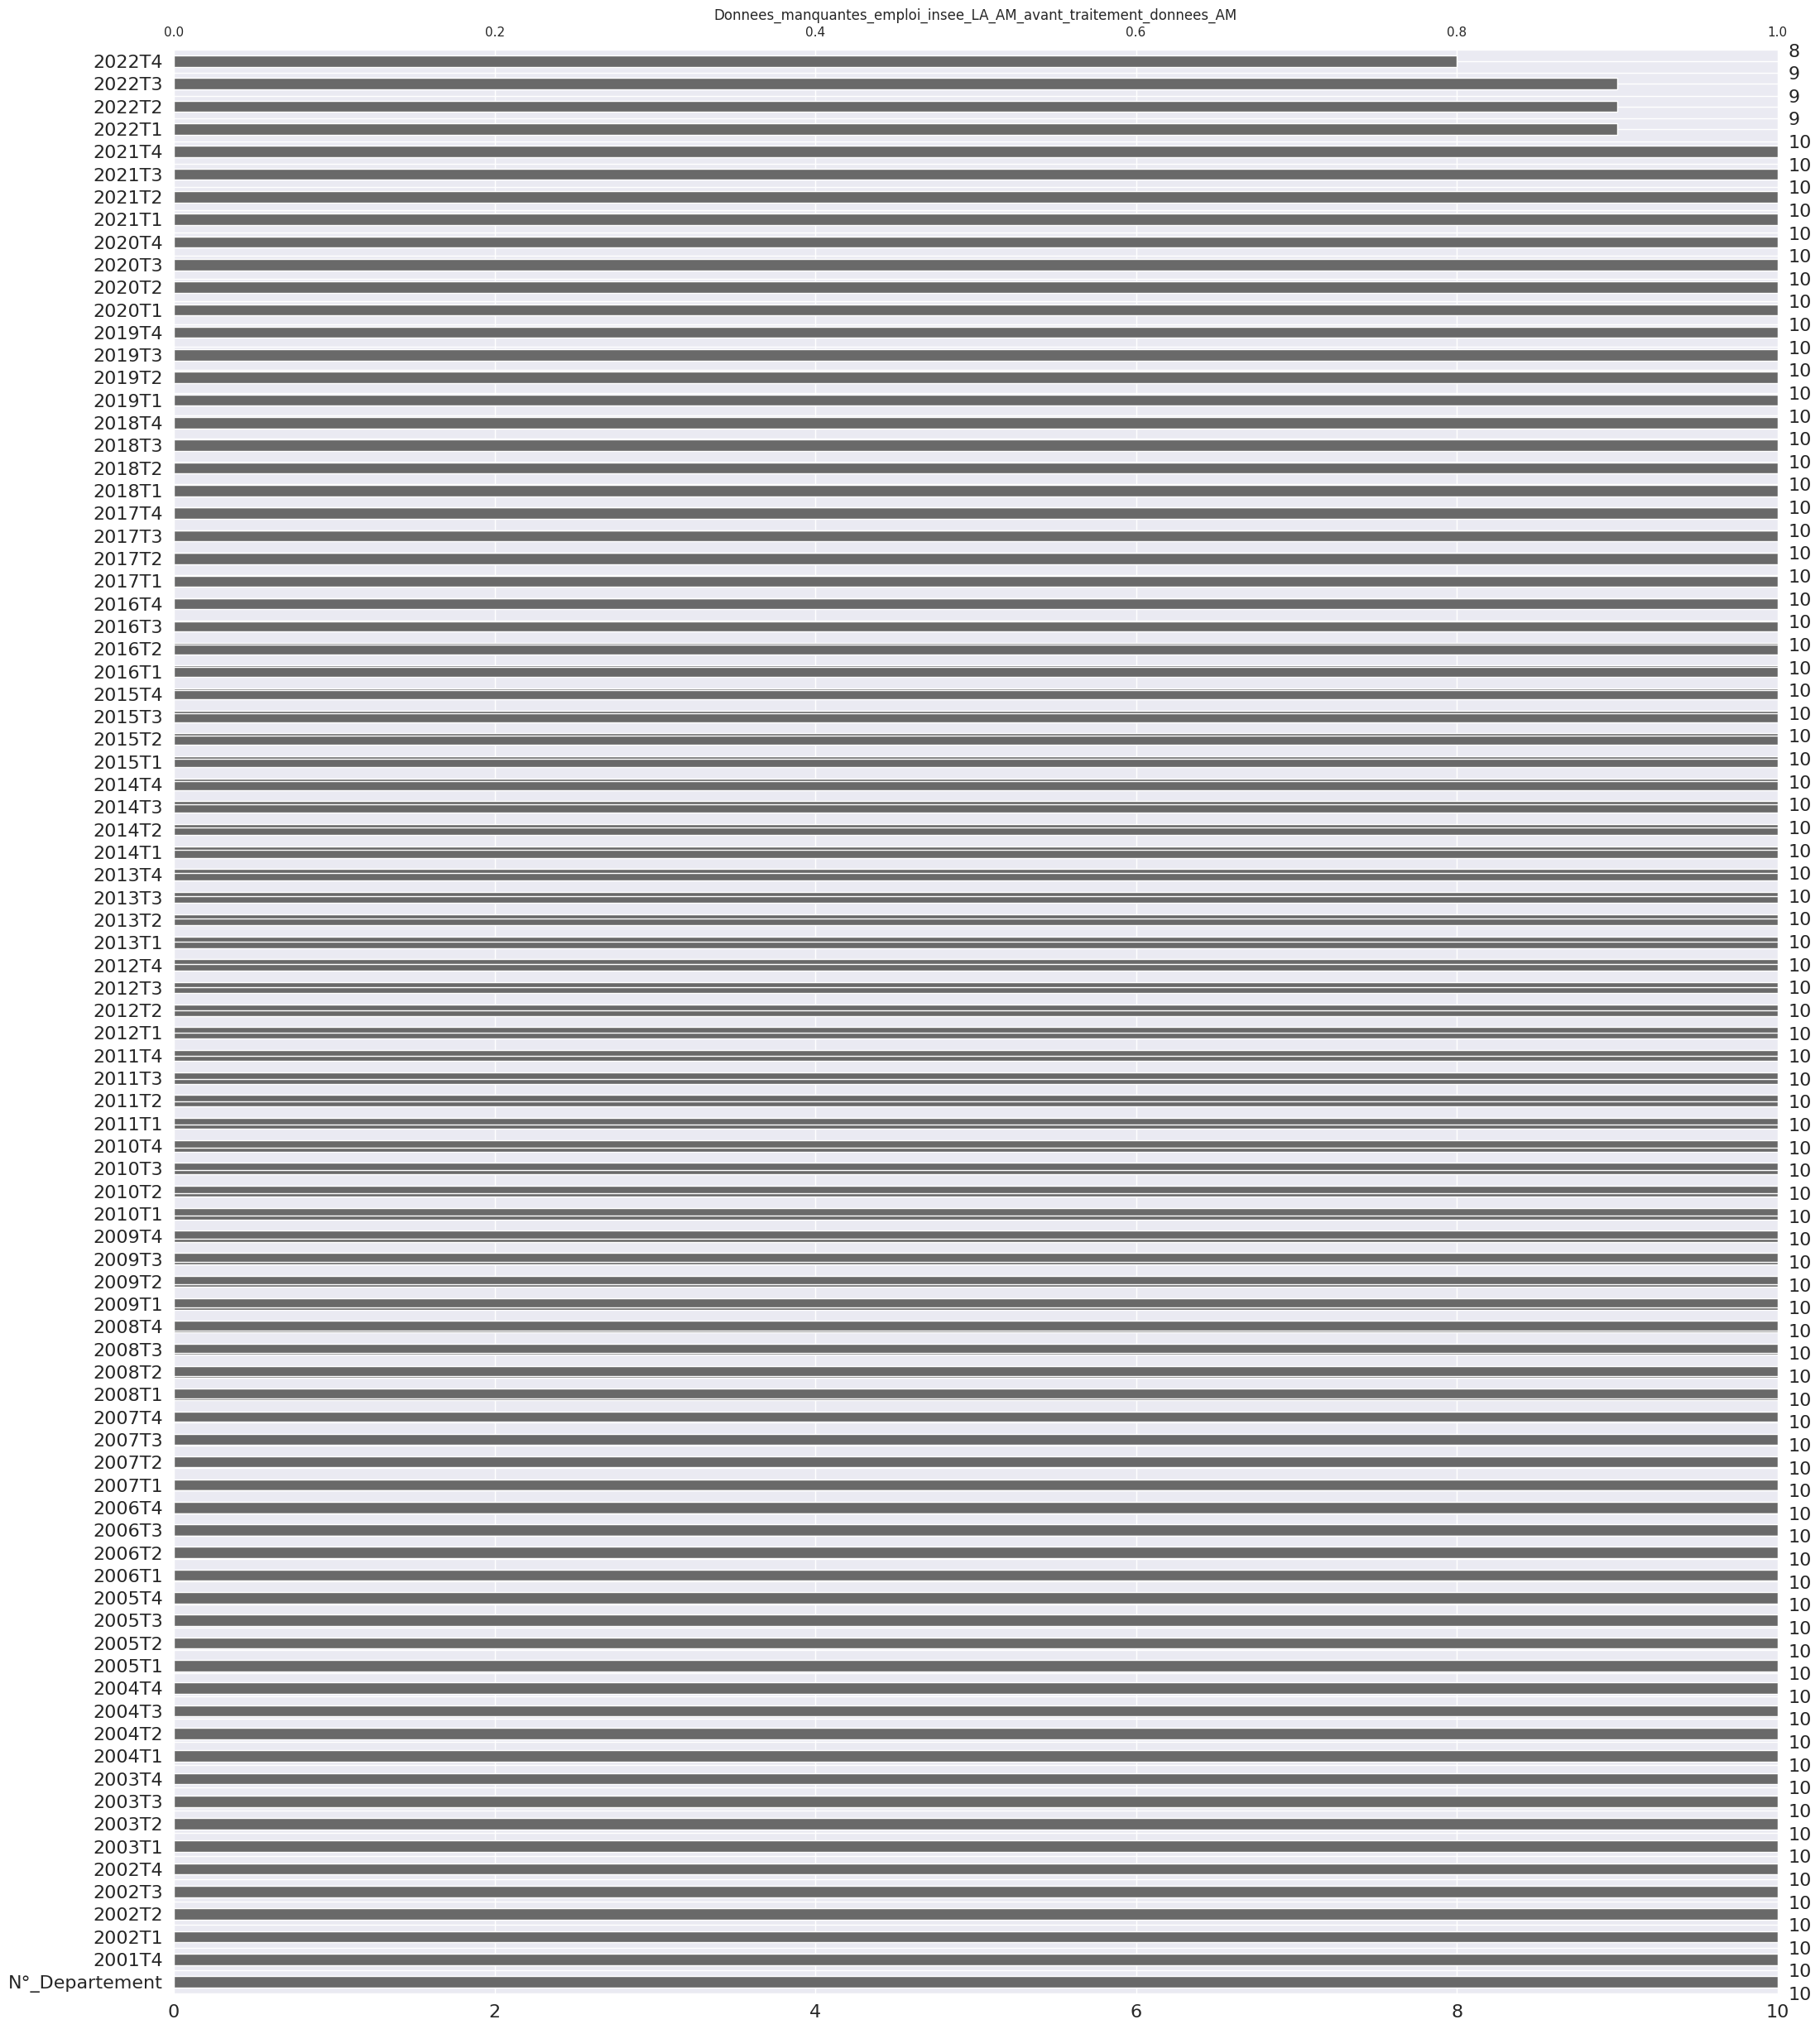

In [159]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_avant_traitement_donnees_AM"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

In [160]:
nan_values_dataframe = dataset_insee.isna()
missing_values_row_indexes = nan_values_dataframe[(nan_values_dataframe["2022T1"] == True)|(nan_values_dataframe["2022T2"] == True)|(nan_values_dataframe["2022T3"].isnull().any() == True)|(nan_values_dataframe["2022T4"] == True)].index
display(missing_values_row_indexes)
rows_w_missing_values = dataset_insee.loc[missing_values_row_indexes]
interesting_columns = [column for column in rows_w_missing_values if "2022" in column]
for column in interesting_columns :
    print("\n"+ column)
    print(rows_w_missing_values[column].isna())

Index(['Emploi Indus LA', 'Tertiaire non march AM OK'], dtype='object')


2022T1
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T1, dtype: bool

2022T2
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T2, dtype: bool

2022T3
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T3, dtype: bool

2022T4
Emploi Indus LA              True
Tertiaire non march AM OK    True
Name: 2022T4, dtype: bool


## Régression linéaire sur la série Tertiaire non marchand AM présentant des données manquantes
### Détermination de la droite de régression linéaire (d'ajustement)

In [161]:
rows_w_missing_values.columns = range(rows_w_missing_values.columns.size)
regressor_wrappers_dict = {}
# Régression linéaire sur les données manquantes
previous_data_slice = slice(1,82)
target_slice = slice(82, None)
#Plaçage des features et des labels dans des tableaux à une dimension, Travail avec les données emploi Indus LA
x = rows_w_missing_values.columns[previous_data_slice].to_numpy().reshape(-1,1)
for i in range(len(rows_w_missing_values)):
    current_series_name = rows_w_missing_values.index[i]
    y = rows_w_missing_values.iloc[i,previous_data_slice].to_numpy().reshape(-1,1)
    #Découpage des données en jeux d'entraînement et de test
    #splitted_datasets_tuple = train_test_split(x, y, test_size=0.2, train_size=0.8)
    #Préparation des données à la régression linéaire
    #X_train, X_test, y_train, y_test = map(lambda dataset : dataset.reshape(1,dataset.shape[0]), splitted_datasets_tuple)
    
    regression_model = LinearRegression()
    # Adapter les données (entraînement du modèle)
    regression_model.fit(x,y)
    # Prédiction
    y_predicted = regression_model.predict(x)
    
    regressor_wrappers_dict[current_series_name] = RegressorWrapper(regression_model, x, y, y_predicted)
    r2 = r2_score(y, y_predicted)
    corr_coef = math.sqrt(r2)
    print(corr_coef)
    print(regression_model.intercept_)

0.3012612648782639
[83255.62808642]
0.94462803098395
[126506.09854048]


0.3012612648782639
0.94462803098395


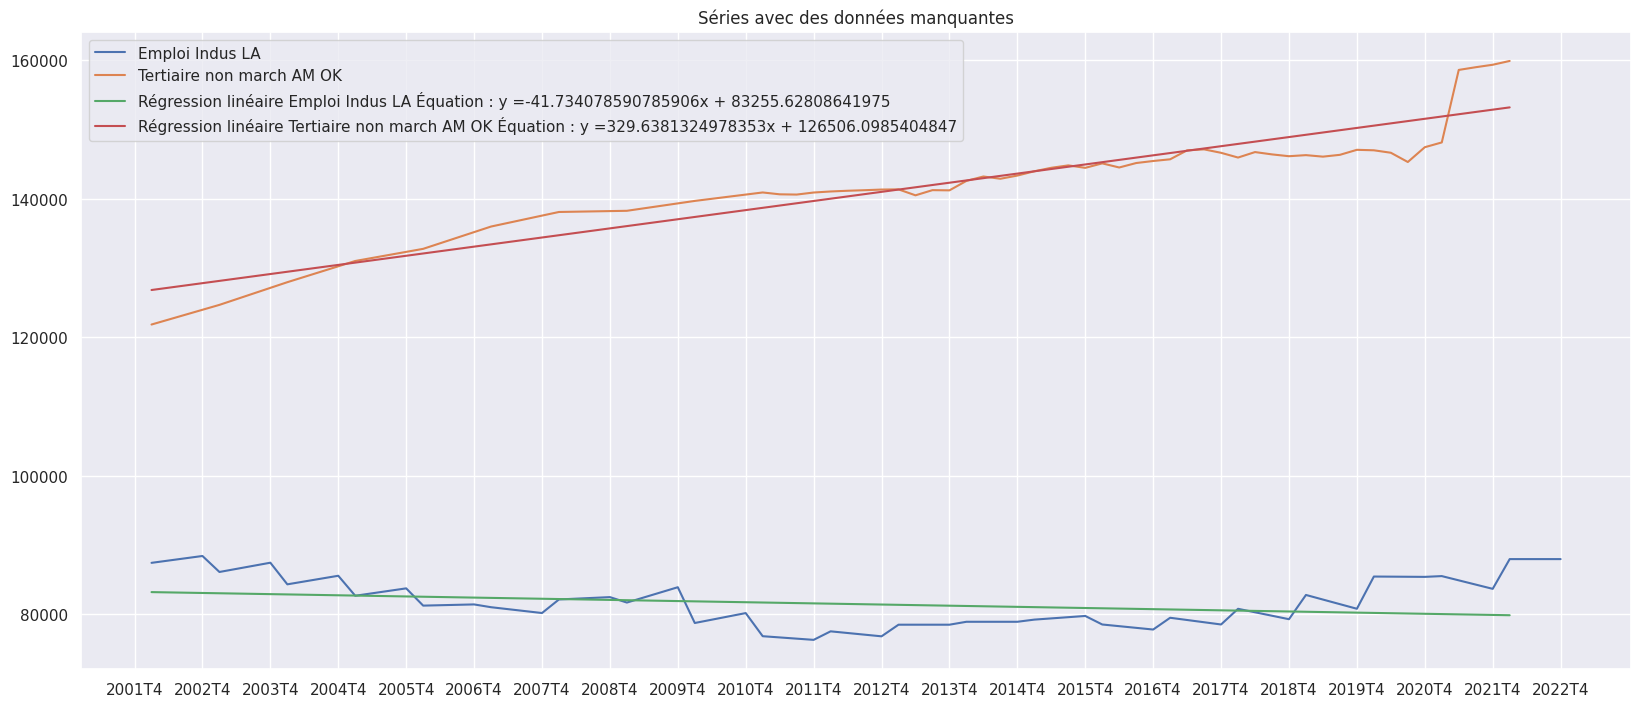

In [162]:
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
x_y_axis_dataframe_slicing = slice(1,None)
title = "Séries avec des données manquantes"
for row_label in rows_w_missing_values.index:
    x = list(rows_w_missing_values.columns)[x_y_axis_dataframe_slicing]
    y = rows_w_missing_values.loc[row_label].iloc[x_y_axis_dataframe_slicing]
    plt.xticks(range(0,85,4),labels=ticks_labels)
    plt.plot(x,y,label=row_label)
for name,value in regressor_wrappers_dict.items():
    plt.plot(x[0:81], value.y_predicted, label="Régression linéaire " + name + " Équation : " + value.get_linear_equation())
    r2 = r2_score(value.y, value.y_predicted)
    corr_coef = math.sqrt(r2)
    print(corr_coef)
plt.title(title)
plt.legend()
plt.savefig(title + ".png")
plt.show()

### Analyse des résidus pour l'emploi dans le secteur tertiaire en Alpes Maritimes

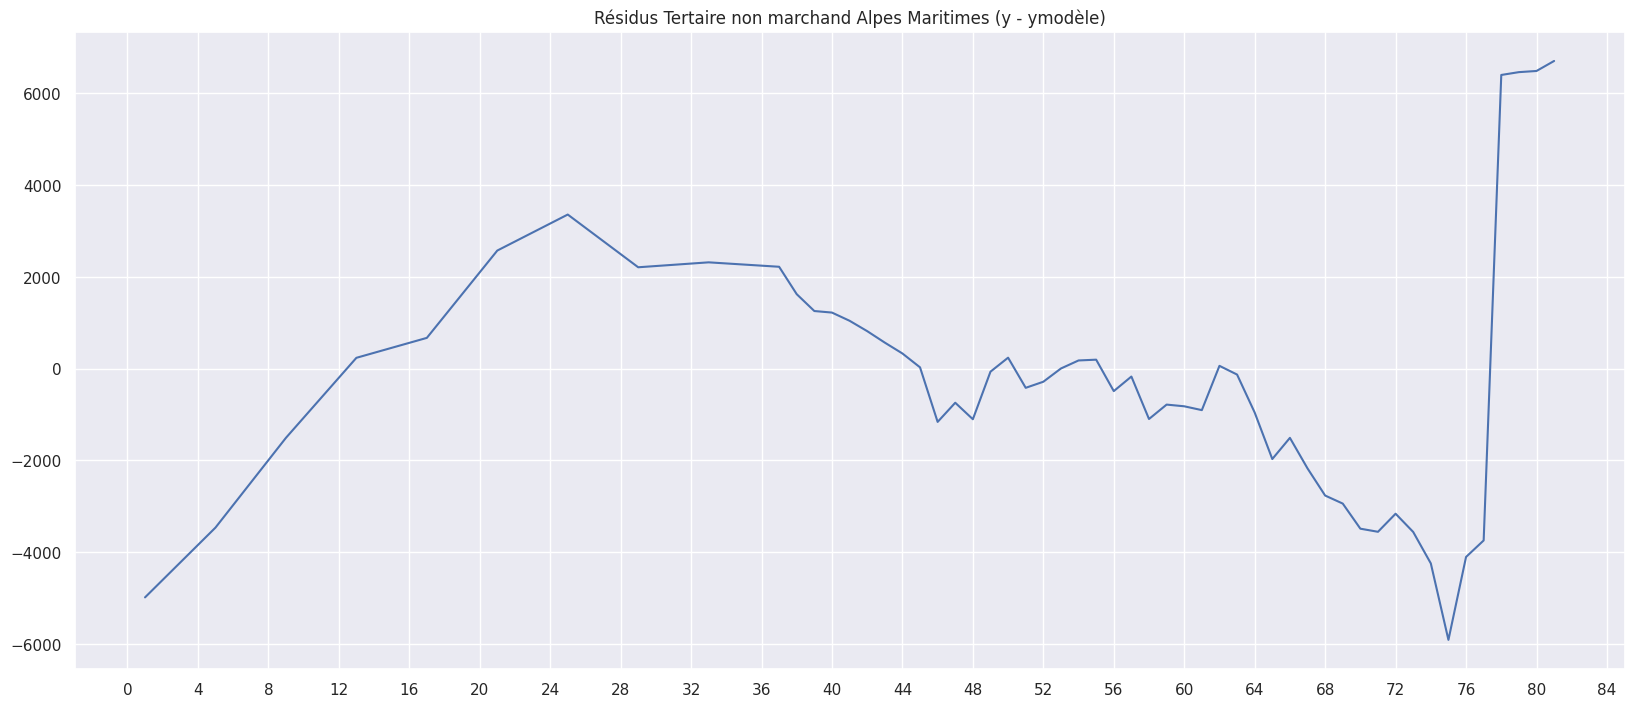

In [163]:
tnm_reg_wrapper = regressor_wrappers_dict[rows_w_missing_values.index[1]]
residuals = tnm_reg_wrapper.get_residuals()
title = "Résidus Tertaire non marchand Alpes Maritimes (y - ymodèle)"
plt.xticks(range(0,85,4))
plt.title(title)
plt.plot(tnm_reg_wrapper.x.tolist(),residuals)
plt.savefig(title + ".png")

### Remplissage des valeurs manquantes avec les prédictions du modèle de Régression linéaire sur les données de l'emploi dans le secteur marchand en Alpes-Maritimes

In [164]:
nan_values = rows_w_missing_values[rows_w_missing_values.columns[rows_w_missing_values.isnull().any()]]
for x in nan_values :
    row_label, column_label = ('Tertiaire non march AM OK',dataset_insee.columns[x])
    cell = dataset_insee.at[row_label, column_label]
    if cell != np.nan:
        dataset_insee.at[row_label, column_label] = tnm_reg_wrapper.predict(np.array([[x]]))

### Affichage de graphiques montrant les valeurs manquantes après le traitement des données du secteur Tertiaire non marchand Alpes Maritimes

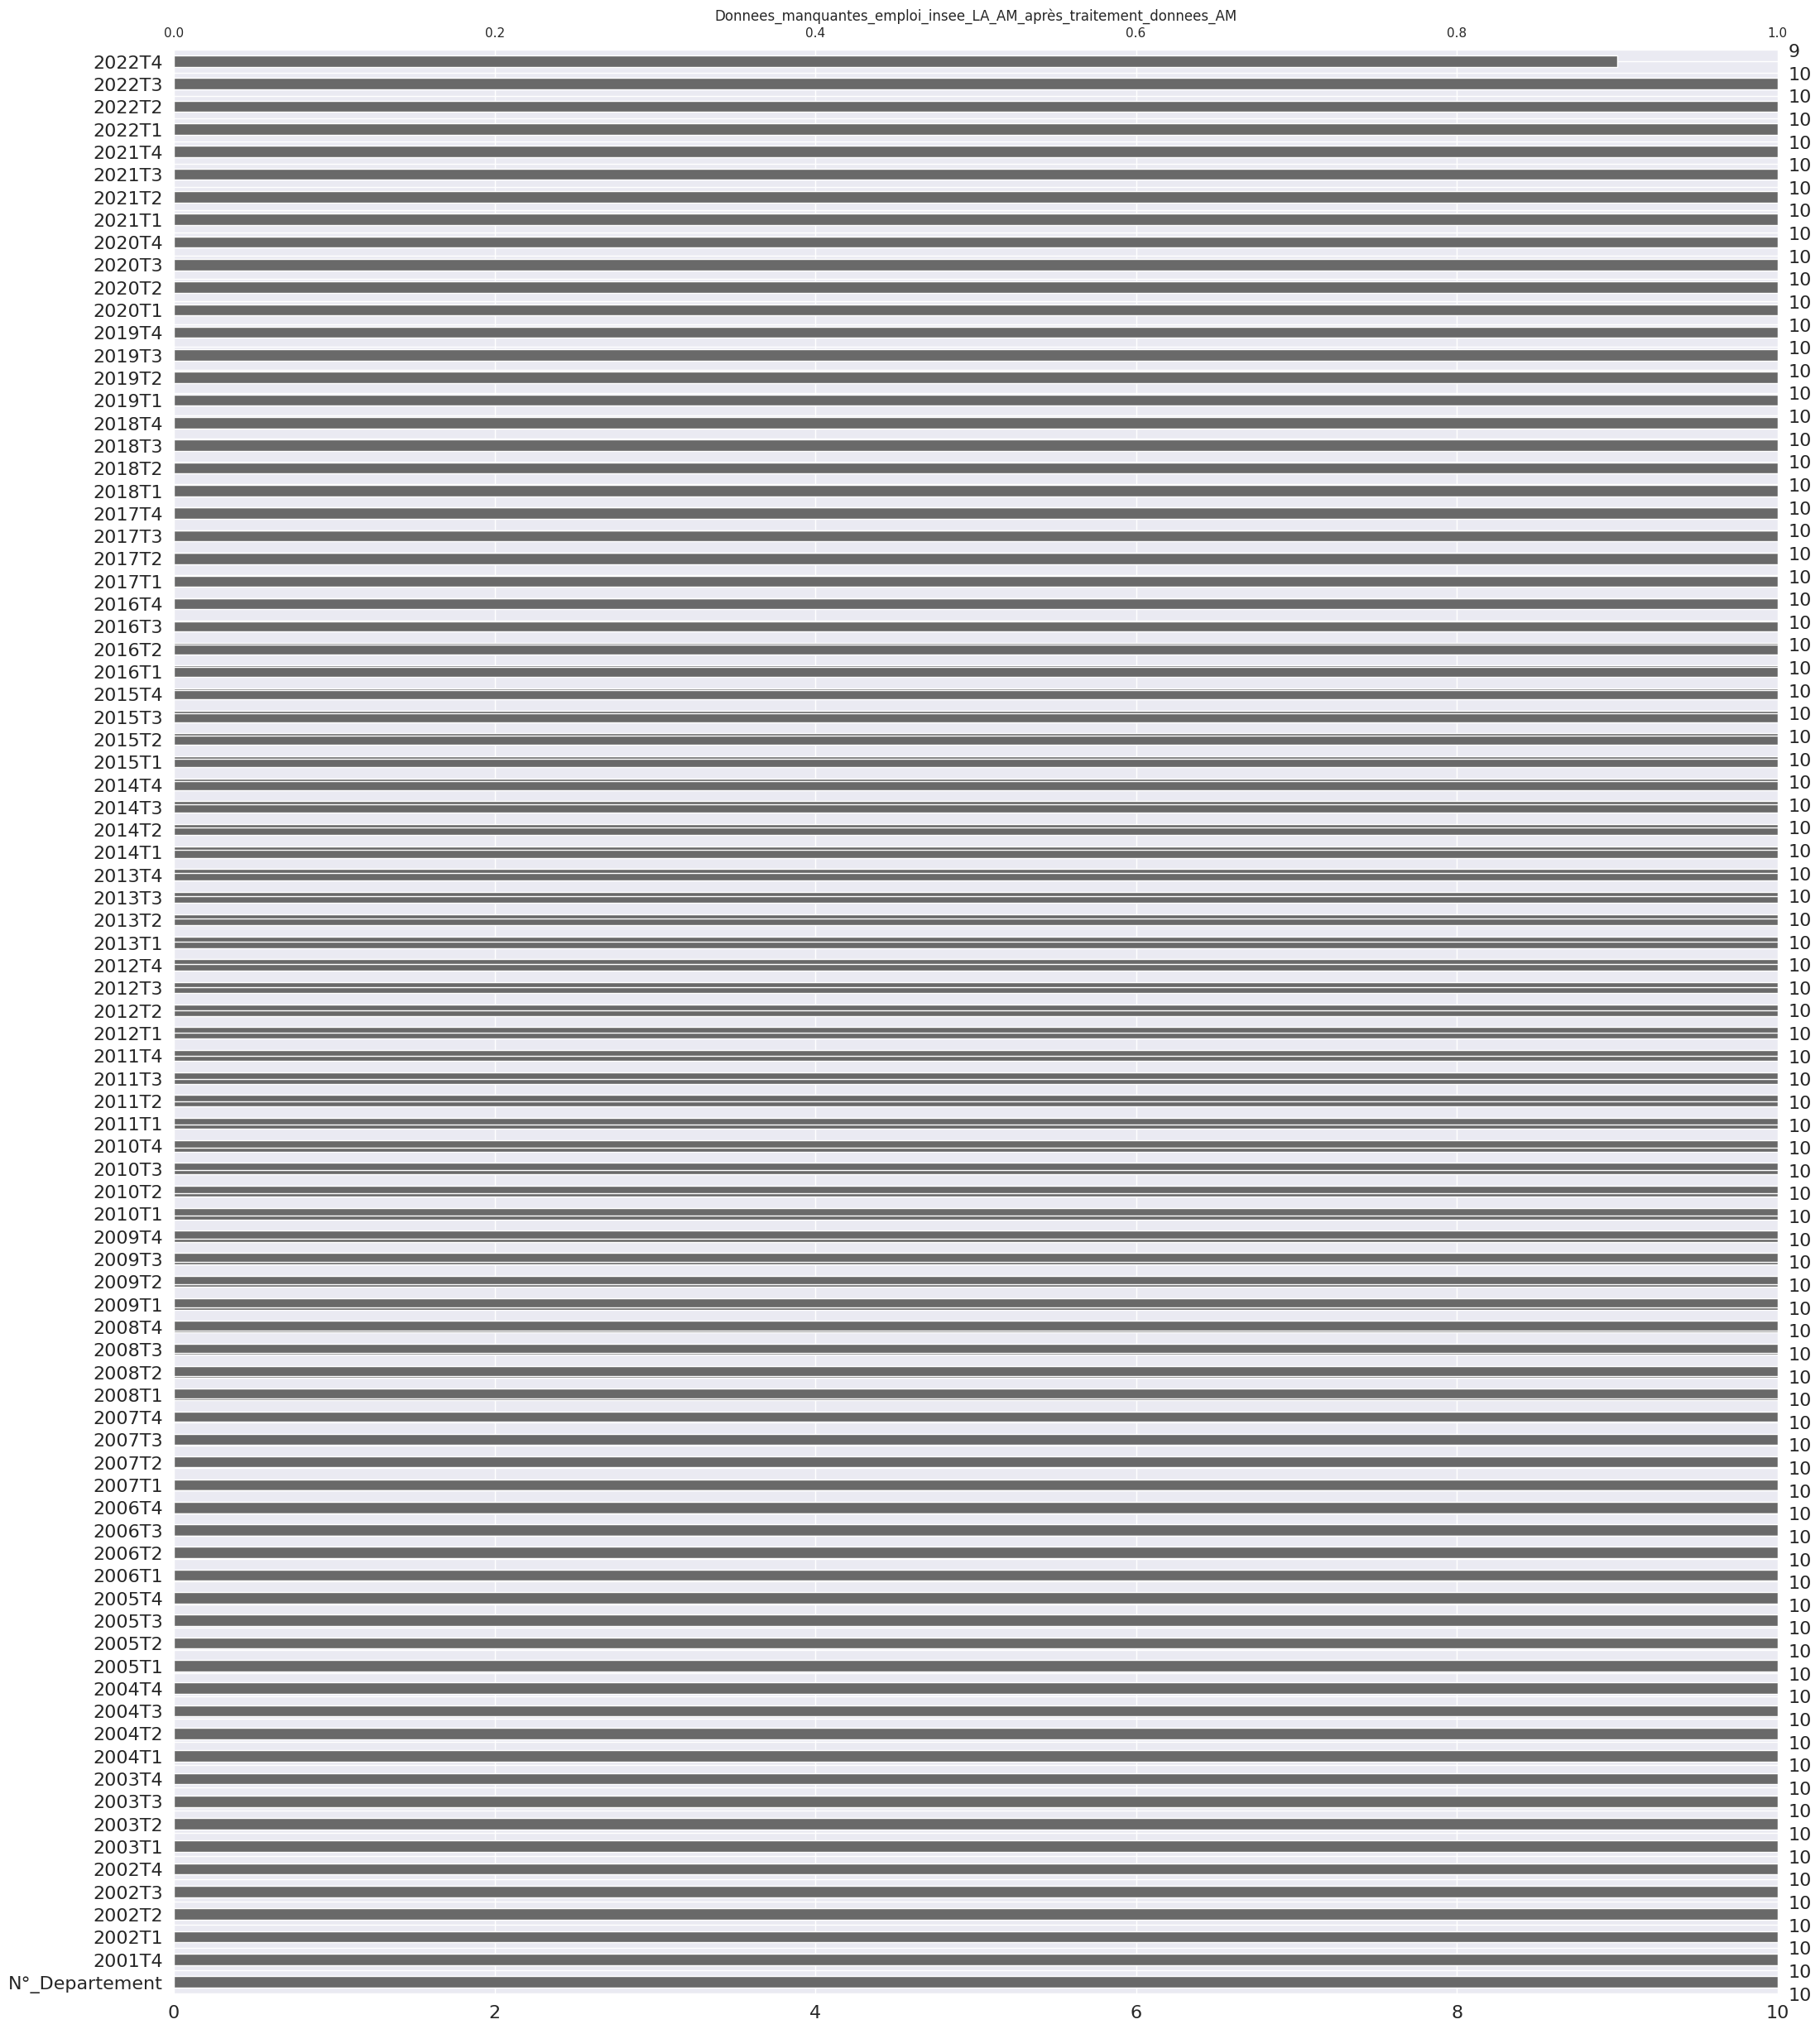

In [165]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_après_traitement_donnees_AM"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

In [166]:
nan_values_dataframe = dataset_insee.isna()
missing_values_row_indexes = nan_values_dataframe[(nan_values_dataframe["2022T1"] == True)|(nan_values_dataframe["2022T2"] == True)|(nan_values_dataframe["2022T3"].isnull().any() == True)|(nan_values_dataframe["2022T4"] == True)].index
missing_values_row_indexes
rows_w_missing_values = dataset_insee.loc[missing_values_row_indexes]
rows_w_missing_values.isna().sum(axis=AXE_COLONNES)

Emploi Indus LA    1
dtype: int64

## Traitement des données manquantes sur la série Emploi Indus LA

### Essai de la méthode d'interpolation linéaire 

In [167]:
dataset_insee = dataset_insee.interpolate(method="linear")
dataset_insee["2022T2"]

Emploi LA                    640581.000000
Emploi Indus LA               87980.000000
Tertiaire marchand LA        263290.000000
Tertiaire non march LA       187742.213883
Chom LA                           6.000000
Emploi AM                    433844.000000
Emploi Indus AM               33107.400000
Tertiaire march AM           193891.600000
Tertiaire non march AM OK    153866.063538
Chom AM                           8.200000
Name: 2022T2, dtype: float64

### Affichage des données manquantes après la méthode d'interpolation linéaire

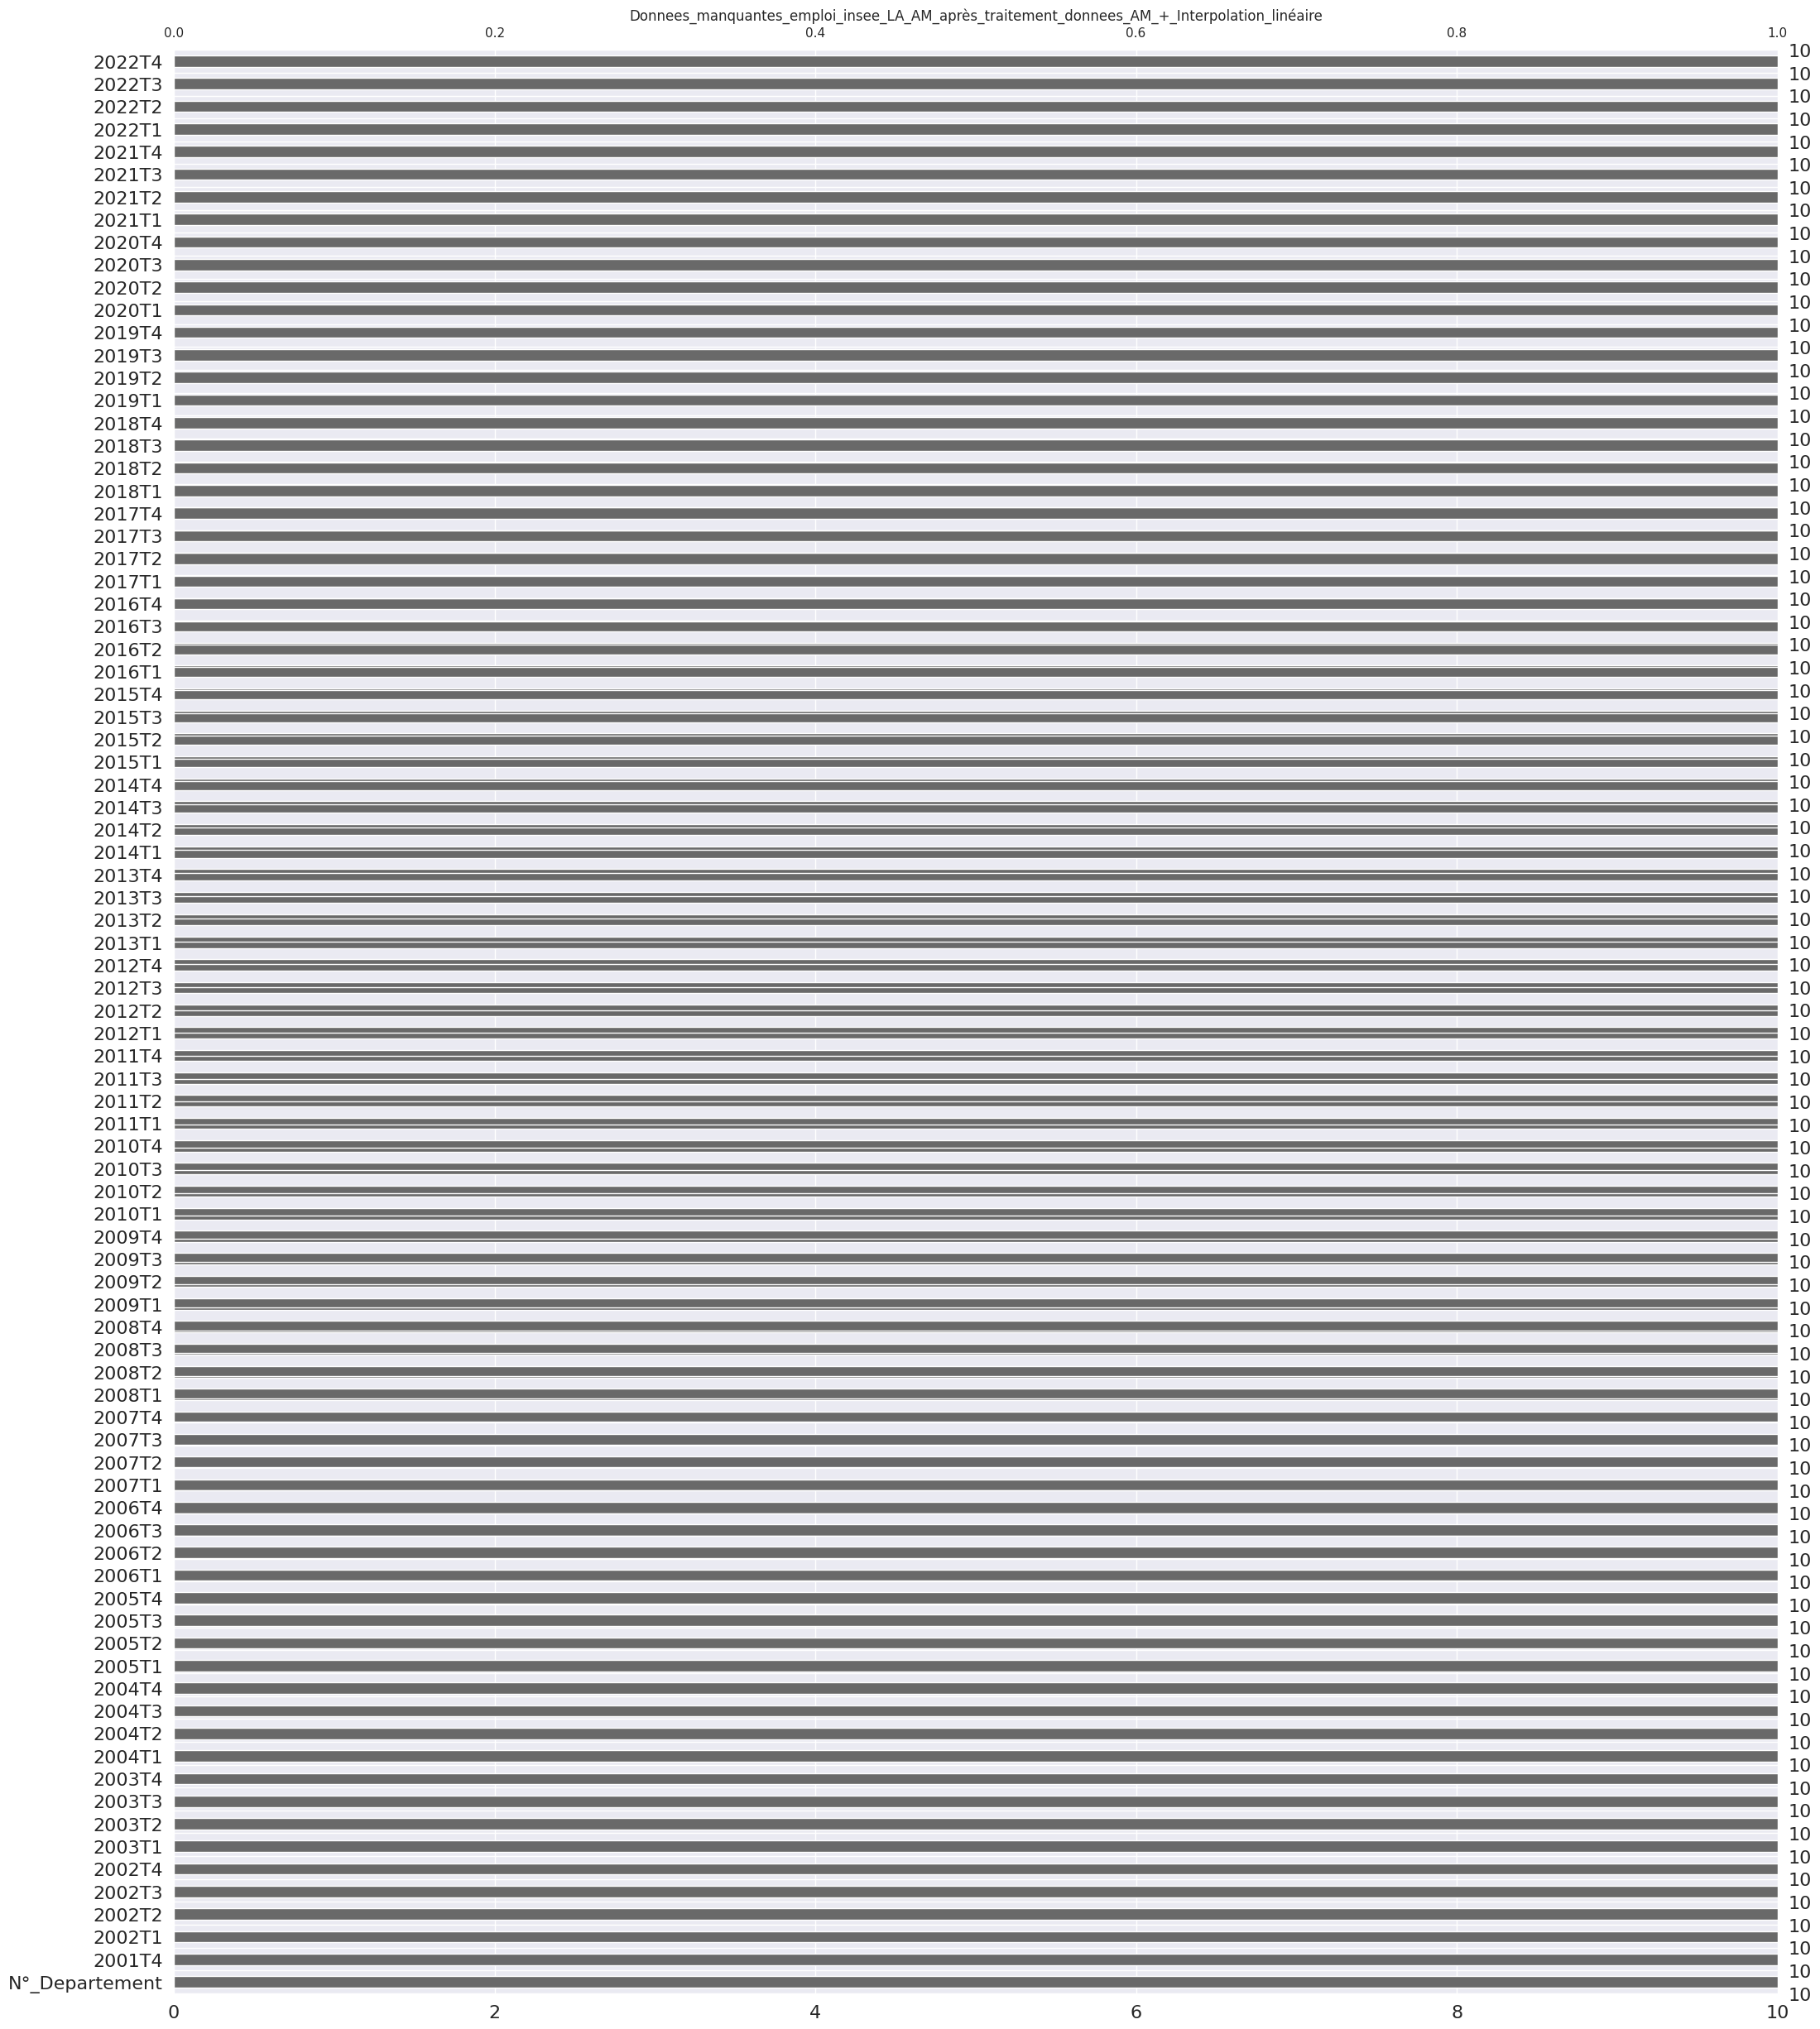

In [168]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_après_traitement_donnees_AM_+_Interpolation_linéaire"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

##

## Affichage de graphiques décrivant les données

In [169]:
dataset_insee_44 = dataset_insee[dataset_insee["N°_Departement"] == 44]
dataset_insee_44['2022T4']

Emploi LA                 645104.0
Emploi Indus LA           455653.0
Tertiaire marchand LA     266202.0
Tertiaire non march LA    188216.0
Chom LA                        5.8
Name: 2022T4, dtype: float64

In [170]:
dataset_insee_06 = dataset_insee[dataset_insee["N°_Departement"] == 6]
dataset_insee_06

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.00000,434185.000000
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.20000,33505.000000
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.00000,194307.000000
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,153536.425405,153866.063538,154195.70167,154525.339803
Chom AM,6,10.2,10.00,9.8,9.60,9,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.300000,8.200000,8.20000,8.000000


In [171]:
chomage_LA = dataset_insee_44.loc['Chom LA'].iloc[1:]
chomage_LA

2001T4    6.5
2002T1    6.4
2002T2    6.4
2002T3    6.4
2002T4    6.0
         ... 
2021T4    6.1
2022T1    5.9
2022T2    6.0
2022T3    6.0
2022T4    5.8
Name: Chom LA, Length: 85, dtype: float64

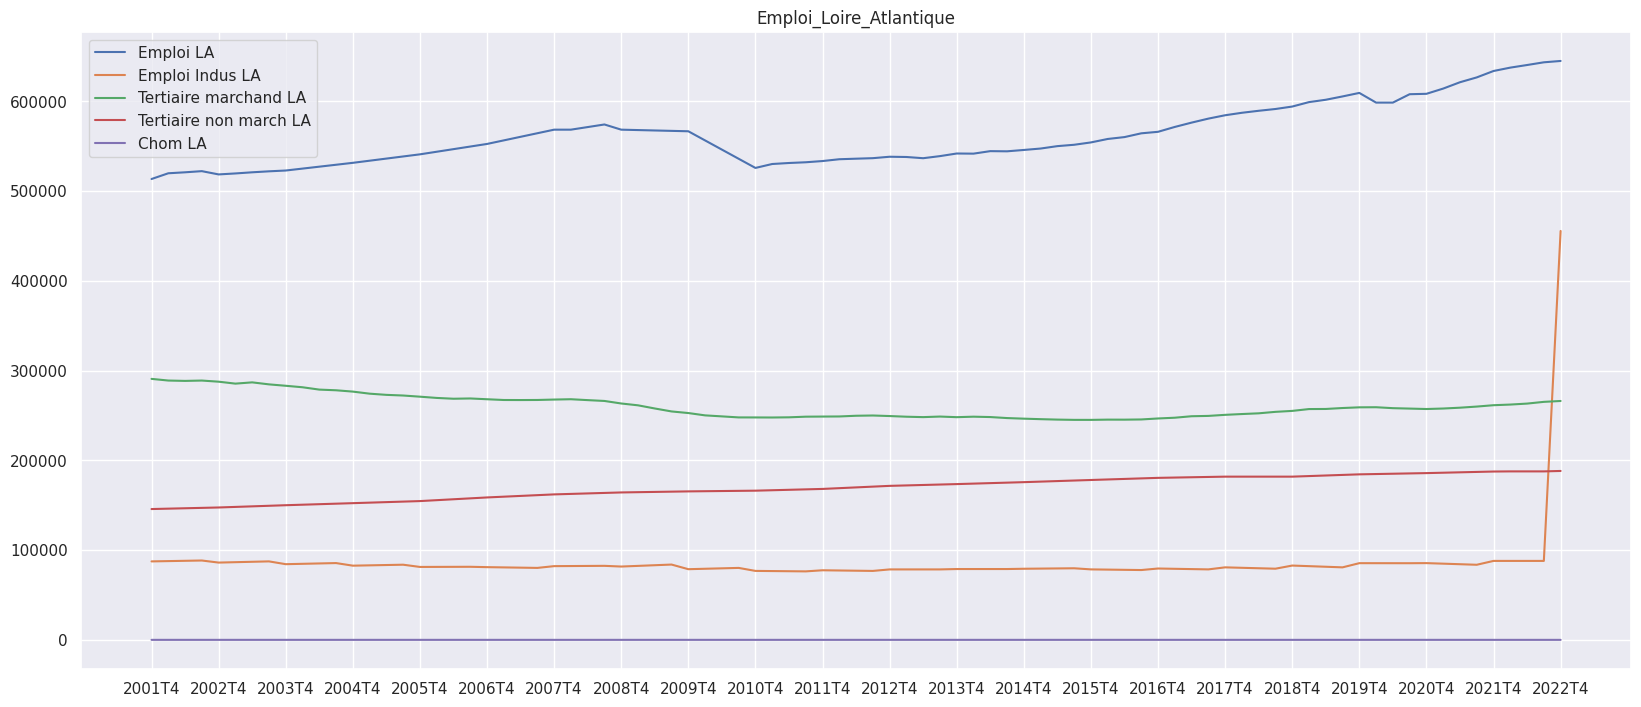

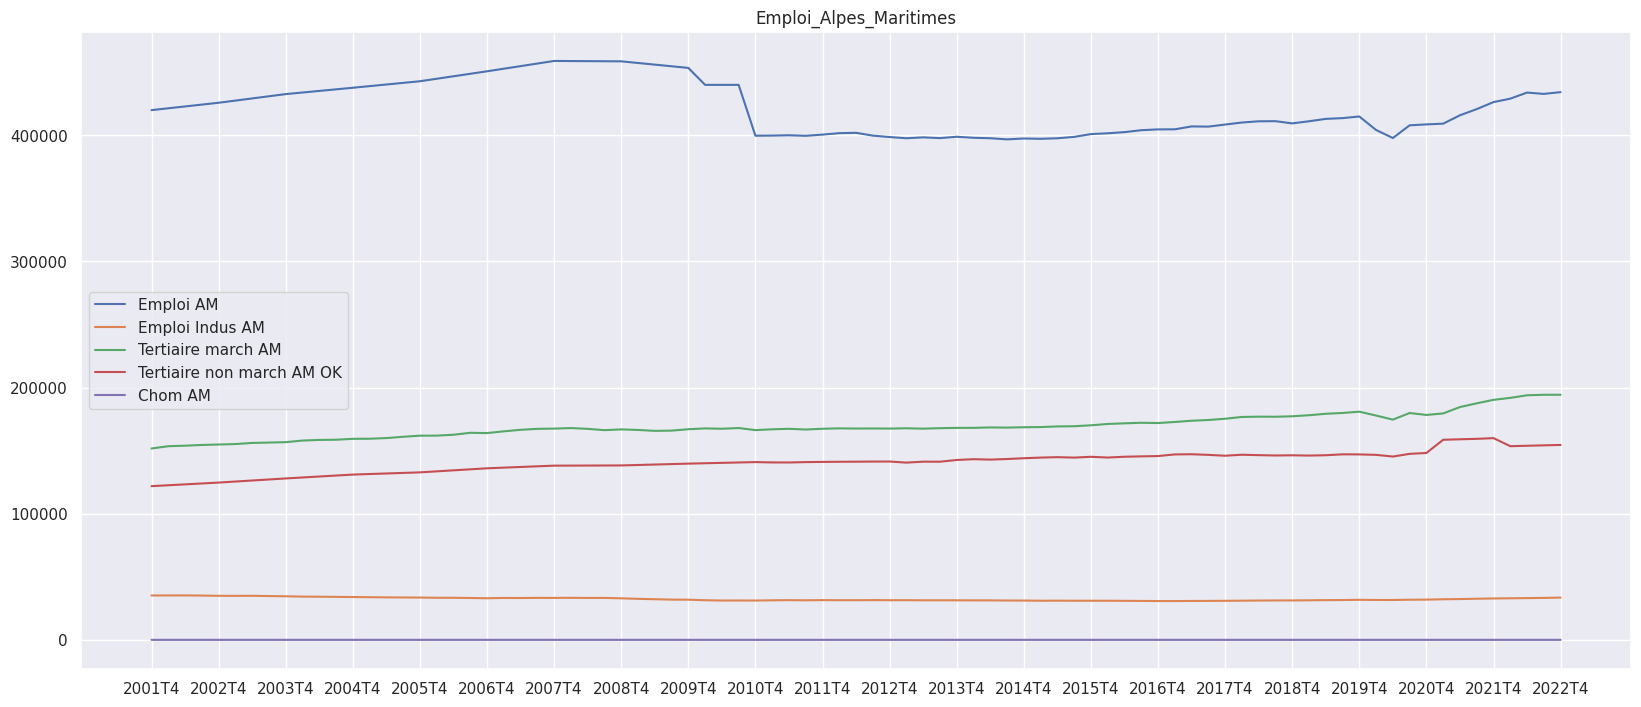

In [172]:
dataframes = [dataset_insee_44, dataset_insee_06]
x_y_axis_dataframe_slicing = slice(1,None)
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    departement = "Loire_Atlantique" if i == 0 else "Alpes_Maritimes"
    title = "Emploi_" + departement
    for row_label in dataframe.index:
        x = list(dataframe.columns)[x_y_axis_dataframe_slicing]
        y = dataframe.loc[row_label].iloc[x_y_axis_dataframe_slicing]
        plt.xticks(range(0,85,4),labels=ticks_labels)
        plt.plot(x,y,label=row_label)
    plt.title(title)
    plt.legend()
    plt.savefig(title + ".png")
    plt.show()

In [173]:
proportions = []
for i in range(len(dataframes)) :
    zone = "LA" if i == 0 else "AM"
    libelle_colonne_emploi = "Emploi {}".format(zone)
    libelle_colonne_num_departement = "N°_Departement"
    dataframe = dataframes[i].drop(libelle_colonne_num_departement, axis=AXE_COLONNES)
    display(afficher_noms_colonnes_avec_valeurs_manquantes(dataframe))
    libelles_lignes_emploi_et_chomage = [libelle_colonne_emploi,"Chom {}".format(zone)]
    serie_emploi_total = dataframe.loc[libelle_colonne_emploi]
    dataframe_sans_emploi_total_ni_chomage = dataframe.drop(libelles_lignes_emploi_et_chomage, axis=0)
    proportion_emploi_par_secteur = dataframe_sans_emploi_total_ni_chomage.divide(serie_emploi_total).mul(100)
    display(proportion_emploi_par_secteur)
    display(proportion_emploi_par_secteur.sum(axis=0))
    proportions.append(proportion_emploi_par_secteur)

None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus LA,17.026613,16.880535,16.908573,16.930285,16.604295,16.655347,16.700046,16.750667,16.125036,16.137844,...,14.047269,14.055287,13.822014,13.566177,13.351825,13.878854,13.796910,13.734407,13.669918,70.632487
Tertiaire marchand LA,56.632181,55.577449,55.385392,55.324001,55.468538,54.937230,55.071785,54.530881,54.136465,53.601569,...,42.386033,42.275311,41.963902,41.636104,41.477603,41.249602,41.119435,41.101750,41.208944,41.264974
Tertiaire non march LA,28.386386,28.120874,28.145737,28.160168,28.442141,28.504103,28.555307,28.616752,28.688442,28.680402,...,30.504468,30.538524,30.320204,30.046299,29.858465,29.591396,29.441492,29.308115,29.170500,29.176071


2001T4    102.045180
2002T1    100.578858
2002T2    100.439702
2002T3    100.414454
2002T4    100.514974
             ...    
2021T4     84.719852
2022T1     84.357837
2022T2     84.144271
2022T3     84.049362
2022T4    141.073532
Length: 85, dtype: float64

None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus AM,8.383514,8.357679,8.335759,8.276894,8.204857,8.161918,8.141457,8.060217,7.986926,7.904812,...,7.800736,7.809237,7.864202,7.779790,7.751506,7.700024,7.685864,7.631176,7.687768,7.716757
Tertiaire march AM,36.129140,36.429783,36.405010,36.411566,36.372839,36.310853,36.374015,36.296784,36.227145,36.413064,...,44.085299,43.632403,43.867829,44.381263,44.568532,44.632654,44.715124,44.691548,44.890141,44.752122
Tertiaire non march AM OK,29.018115,29.085957,29.153329,29.220238,29.286687,29.360630,29.433982,29.506749,29.578940,29.669609,...,36.151518,36.255754,38.762853,38.237677,37.877890,37.512286,35.788459,35.465758,35.629037,35.589746


2001T4    73.530769
2002T1    73.873419
2002T2    73.894099
2002T3    73.908698
2002T4    73.864384
            ...    
2021T4    89.844964
2022T1    88.189446
2022T2    87.788482
2022T3    88.206946
2022T4    88.058625
Length: 85, dtype: float64

In [174]:
trimestres_interessants = ["2007T2","2012T2","2017T2","2022T2"]
dataset_insee_proportions_emploi_LA = proportions[0]
dataset_insee_proportions_emploi_AM = proportions[1]
proportions_donnees_elections_LA = dataset_insee_proportions_emploi_LA[trimestres_interessants]
proportions_donnees_elections_AM = dataset_insee_proportions_emploi_AM[trimestres_interessants]
display(proportions_donnees_elections_LA)
proportions_elections = [proportions_donnees_elections_LA,proportions_donnees_elections_AM]
display(proportions_elections)

,2007T2,2012T2,2017T2,2022T2
Emploi Indus LA,14.355183,14.373275,13.682119,13.734407
Tertiaire marchand LA,47.671926,46.575532,43.234193,41.101750
Tertiaire non march LA,28.614216,31.686498,31.438121,29.308115


[                           2007T2     2012T2     2017T2     2022T2
 Emploi Indus LA         14.355183  14.373275  13.682119  13.734407
 Tertiaire marchand LA   47.671926  46.575532  43.234193  41.101750
 Tertiaire non march LA  28.614216  31.686498  31.438121  29.308115,
                               2007T2     2012T2     2017T2     2022T2
 Emploi Indus AM             7.294463   7.822623   7.580220   7.631176
 Tertiaire march AM         36.610400  41.678327  42.678106  44.691548
 Tertiaire non march AM OK  30.134873  35.142790  36.153002  35.465758]

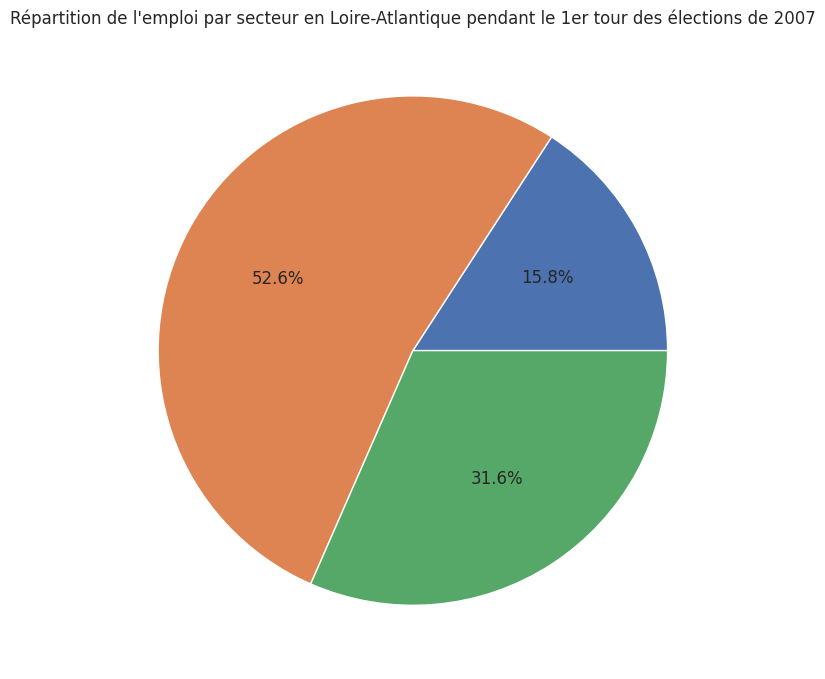

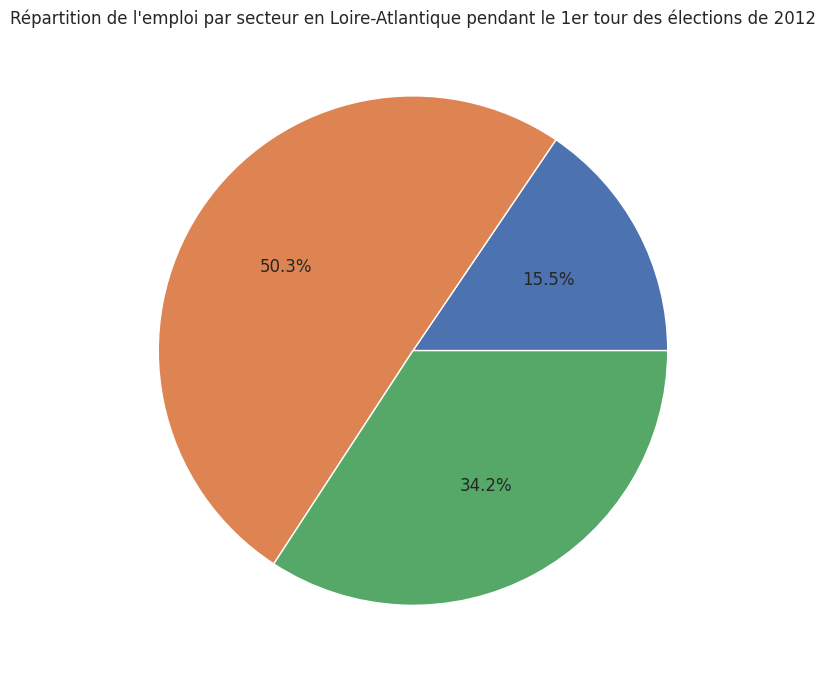

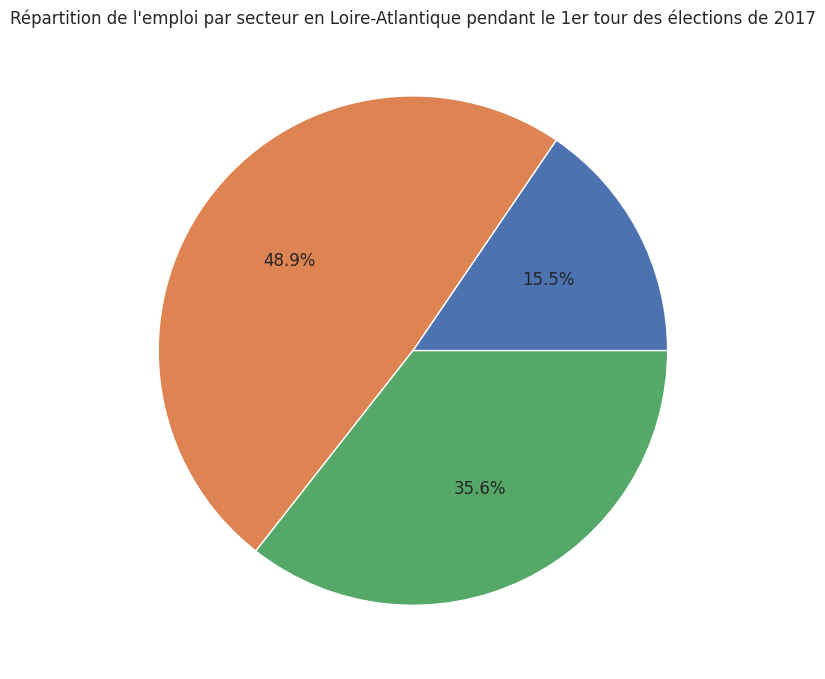

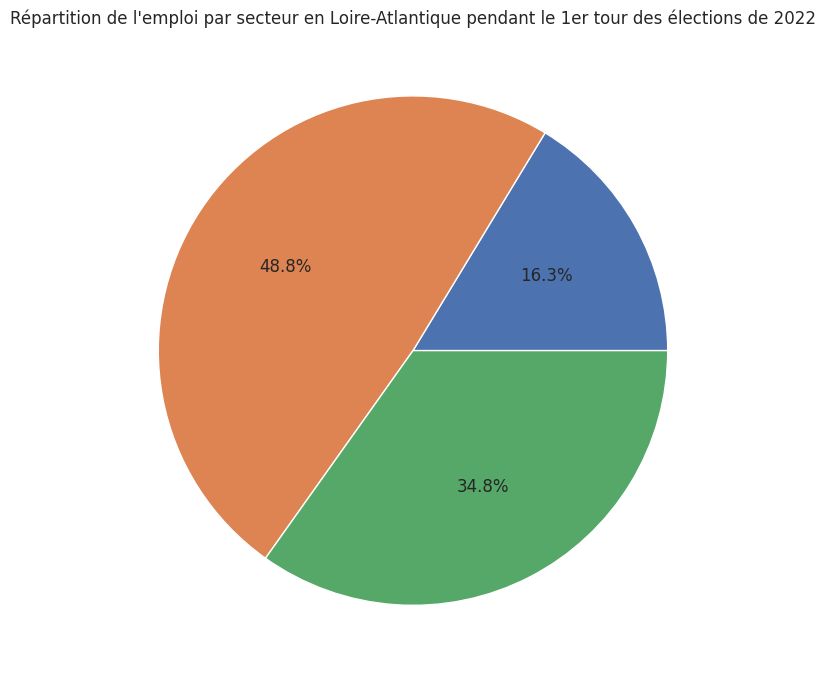

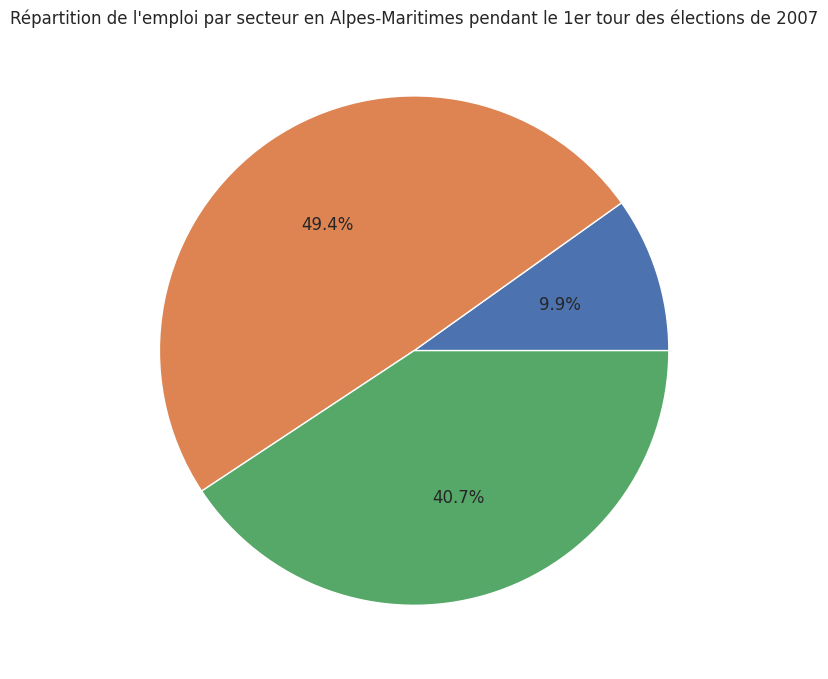

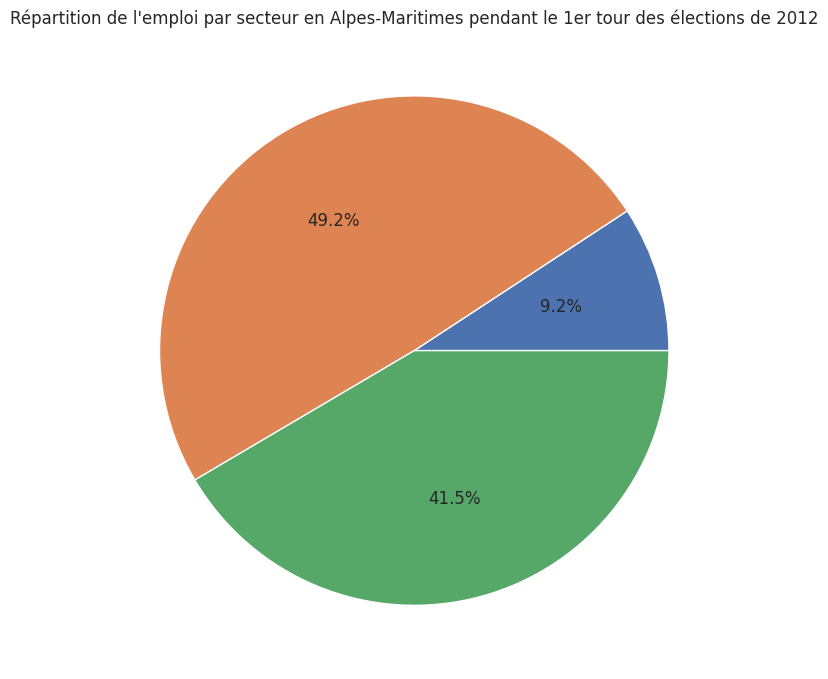

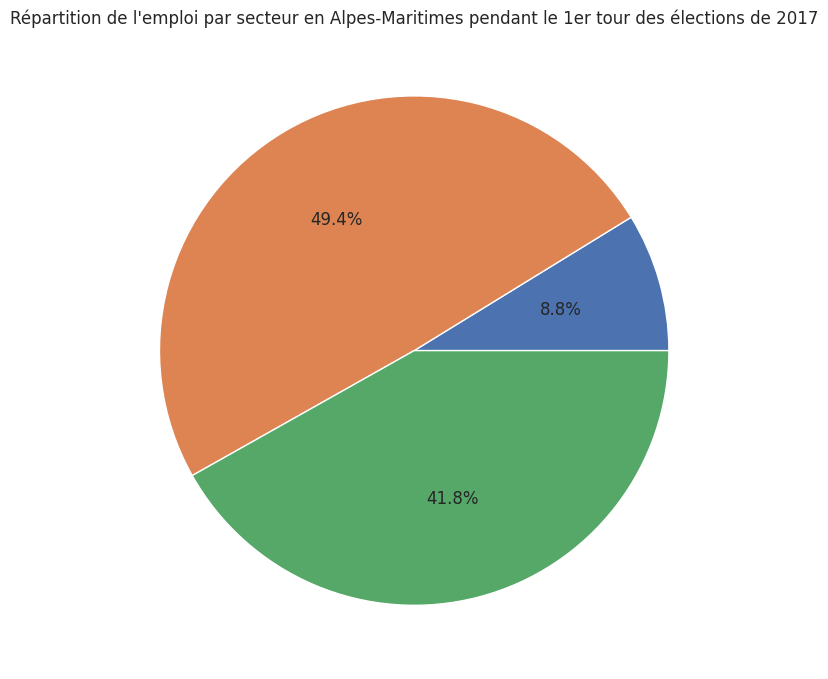

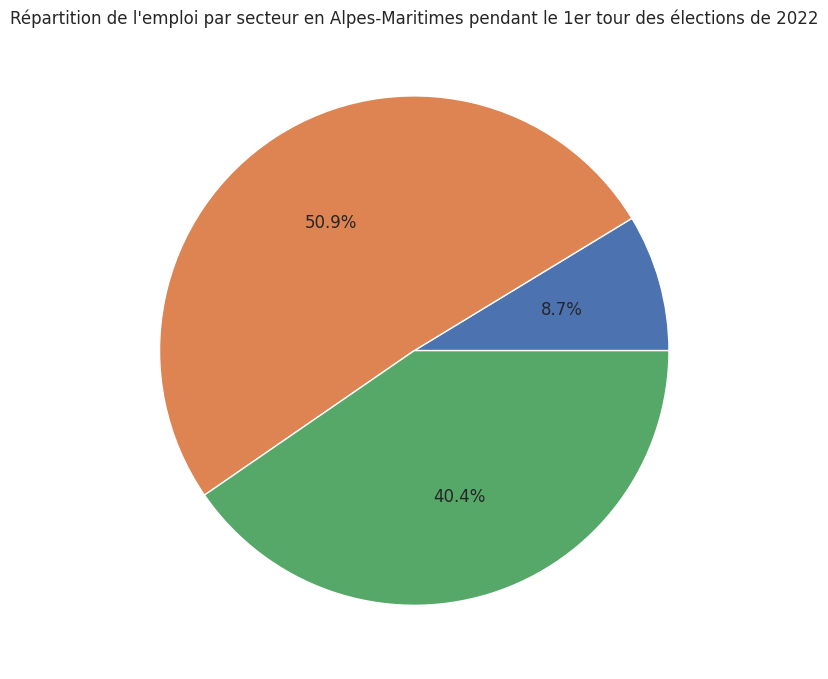

In [175]:
for i in range(len(proportions_elections)) :
    proportion = proportions_elections[i]
    zone = "Loire-Atlantique" if i == 0 else "Alpes-Maritimes"
    for column in proportion.columns:
        title = 'Répartition de l\'emploi par secteur en {} pendant le 1er tour des élections de {}'.format(zone, column[0:4])
        fig, ax = plt.subplots()
        plt.title(title)
        ax.pie(proportion[column], autopct='%1.1f%%')
        plt.savefig(title + ".png")

## Traitement des données des élections
### Obtention d'un jeu de données par candidats

In [176]:
donnees_1er_tour_2007 = pd.read_excel("./data/Presidentielle_2007_Tour_1.xls", sheet_name="Départements T1")
donnees_1er_tour_2012 = pd.read_excel("./data/Presidentielle_2012_Tour_1.xls", sheet_name="Départements T1")
donnees_1er_tour_2017 = pd.read_excel("./data/Presidentielle_2017_Resultats_Tour_1_c.xls", sheet_name="Départements Tour 1")
donnees_1er_tour_2022 = pd.read_excel("./data/resultats-par-niveau-dpt-t1-france-entiere.xlsx")
global_columns = ['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       '% Blancs/Ins', '% Blancs/Vot', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot']
donnees_1er_tour_2022 = donnees_1er_tour_2022.drop("Etat saisie", axis=AXE_COLONNES)
donnees_1er_tour_2022.insert(7,"Blancs et nuls",donnees_1er_tour_2022["Blancs"] + donnees_1er_tour_2022["Nuls"])

dataframes_2017_2022 = [donnees_1er_tour_2017, donnees_1er_tour_2022]
for i in range(len(dataframes_2017_2022)):
    dataframe = dataframes_2017_2022[i]
    display(dataframe.columns)
    percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name = "% BlNuls/Ins"
    dataframe.insert(8,percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name,(dataframe["Blancs et nuls"] / dataframe["Inscrits"]) * 100)    
    percentage_of_null_votes_and_blank_ballots_among_voters_column_name = "% BlNuls/Vot"
    dataframe.insert(9,percentage_of_null_votes_and_blank_ballots_among_voters_column_name,(dataframe["Blancs et nuls"] / dataframe["Votants"]) * 100)
    if i == 0 :
        global_columns.append(percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name)
        global_columns.append(percentage_of_null_votes_and_blank_ballots_among_voters_column_name)
global_columns
display(dataframes_2017_2022)

Index(['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       '% Blancs/Ins', '% Blancs/Vot', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins',
       '% Voix/Exp', 'Sexe.1', 'Nom.1', 'Prénom.1', 'Voix.1', '% Voix/Ins.1',
       '% Voix/Exp.1', 'Sexe.2', 'Nom.2', 'Prénom.2', 'Voix.2', '% Voix/Ins.2',
       '% Voix/Exp.2', 'Sexe.3', 'Nom.3', 'Prénom.3', 'Voix.3', '% Voix/Ins.3',
       '% Voix/Exp.3', 'Sexe.4', 'Nom.4', 'Prénom.4', 'Voix.4', '% Voix/Ins.4',
       '% Voix/Exp.4', 'Sexe.5', 'Nom.5', 'Prénom.5', 'Voix.5', '% Voix/Ins.5',
       '% Voix/Exp.5', 'Sexe.6', 'Nom.6', 'Prénom.6', 'Voix.6', '% Voix/Ins.6',
       '% Voix/Exp.6', 'Sexe.7', 'Nom.7', 'Prénom.7', 'Voix.7', '% Voix/Ins.7',
       '% Voix/Exp.7', 'Sexe.8', 'Nom.8', 'Prénom.8', 'Voix.8', '% Voix/Ins.8',
       '% Voix/Exp.8', 'Sexe.9', 'Nom.9', 'Prénom.9', 'Voi

Index(['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Sexe', 'Nom',
       'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Sexe.1', 'Nom.1',
       'Prénom.1', 'Voix.1', '% Voix/Ins.1', '% Voix/Exp.1', 'Sexe.2', 'Nom.2',
       'Prénom.2', 'Voix.2', '% Voix/Ins.2', '% Voix/Exp.2', 'Sexe.3', 'Nom.3',
       'Prénom.3', 'Voix.3', '% Voix/Ins.3', '% Voix/Exp.3', 'Sexe.4', 'Nom.4',
       'Prénom.4', 'Voix.4', '% Voix/Ins.4', '% Voix/Exp.4', 'Sexe.5', 'Nom.5',
       'Prénom.5', 'Voix.5', '% Voix/Ins.5', '% Voix/Exp.5', 'Sexe.6', 'Nom.6',
       'Prénom.6', 'Voix.6', '% Voix/Ins.6', '% Voix/Exp.6', 'Sexe.7', 'Nom.7',
       'Prénom.7', 'Voix.7', '% Voix/Ins.7', '% Voix/Exp.7', 'Sexe.8', 'Nom.8',
       'Prénom.8', 'Voix.8', '% Voix/Ins.8', '% Voix/Exp.8', 'Sexe.9', 'Nom.9'

[    Code du département           Libellé du département  Inscrits  \
 0                     1                              Ain    415886   
 1                     2                            Aisne    375752   
 2                     3                           Allier    253508   
 3                     4          Alpes-de-Haute-Provence    126578   
 4                     5                     Hautes-Alpes    109907   
 ..                  ...                              ...       ...   
 102                  ZP              Polynésie française    203940   
 103                  ZS         Saint-Pierre-et-Miquelon      4966   
 104                  ZW                 Wallis et Futuna      8464   
 105                  ZX    Saint-Martin/Saint-Barthélemy     25385   
 106                  ZZ  Français établis hors de France   1264113   
 
      Abstentions  % Abs/Ins  Votants  % Vot/Ins  Blancs et nuls  % BlNuls/Ins  \
 0          81507      19.60   334379      80.40            8580

In [177]:
#display(columns_only_present_in_2017_2022)
#dataframes_elections = [donnees_1er_tour_2007,donnees_1er_tour_2012,donnees_1er_tour_2017,donnees_1er_tour_2022]
#Suppression des colonnes seulement présentes en 2017 et 2022 et impossibles à recalculer avec les données de 2007 et 2012
#donnees_1er_tour_2017[columns_only_present_in_2017_2022]
#donnees_1er_tour_2022.drop(columns_only_present_in_2017_2022, axis=1, inplace=True)
#for column_name in columns_only_present_in_2017_2022 :
   #global_columns.remove(column_name)

In [178]:

donnees_1er_tour_2017["Code du département"] = donnees_1er_tour_2017["Code du département"].astype(str)
donnees_1er_tour_2017["Code du département"].unique()
donnees_1er_tour_2017_44_06 = donnees_1er_tour_2017[(donnees_1er_tour_2017["Code du département"] == '44') | (donnees_1er_tour_2017["Code du département"] == '06')]

display(donnees_1er_tour_2017_44_06)
#Isolement des candidats
candidates_df = []
columns = ['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp']
for i in range(11):
    regex = '(Sexe|Nom|Prénom|Voix|% Voix/Ins|% Voix/Exp)'
    if i > 0 :
        regex = regex + '\.' + str(i)
    regex = regex + '$'
    candidates = donnees_1er_tour_2017_44_06.filter(regex=regex)
    candidates.columns = columns
    display(candidates.columns)
    candidates_df.append(candidates)
total_candidates = pd.concat(candidates_df, axis=0)


total_candidates = total_candidates.drop("Voix", axis=AXE_COLONNES).drop("% Voix/Ins", axis=AXE_COLONNES)
total_candidates.rename(index={5: 6}, inplace=True)


display(total_candidates)

,Code du département,Libellé du département,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs et nuls,% BlNuls/Ins,% BlNuls/Vot,...,Prénom.9,Voix.9,% Voix/Ins.9,% Voix/Exp.9,Sexe.10,Nom.10,Prénom.10,Voix.10,% Voix/Ins.10,% Voix/Exp.10
5,06,Alpes-Maritimes,761761,161903,21.25,599858,78.75,11926,1.565583,1.988137,...,Nathalie,1729,0.23,0.29,M,CHEMINADE,Jacques,939,0.12,0.16
44,44,Loire-Atlantique,993538,162597,16.37,830941,83.63,19484,1.961072,2.344811,...,Nathalie,4785,0.48,0.59,M,CHEMINADE,Jacques,1354,0.14,0.17


Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

Index(['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp'], dtype='object')

,Sexe,Nom,Prénom,% Voix/Exp
6,F,LE PEN,Marine,27.75
44,M,MACRON,Emmanuel,28.66
6,M,FILLON,François,27.39
44,M,MÉLENCHON,Jean-Luc,21.98
6,M,MACRON,Emmanuel,19.04
44,M,FILLON,François,19.68
6,M,MÉLENCHON,Jean-Luc,14.96
44,F,LE PEN,Marine,13.70
6,M,DUPONT-AIGNAN,Nicolas,4.28
44,M,HAMON,Benoît,8.03


## Catégorisation des candidats de 2017 par bord politique

In [179]:
donnes_securite_dept = pd.read_csv("./data/donnee-securité.csv",
                                   sep=';')
# Filtrer les données de sécurité sur lles départements 44 et 06
donnees_securite_44_06 = donnes_securite_dept[
 (donnes_securite_dept['Code.département'] == '6') | (donnes_securite_dept['Code.département'] == '06') | (
                donnes_securite_dept['Code.département'] == '44')]

donnees_securite_44_06 = donnees_securite_44_06[(donnees_securite_44_06['annee'] == 17)]



# Faire pivoter les données pour obtenir un DataFrame avec un département par ligne et une colonne par catégorie
df_pivot = donnees_securite_44_06.pivot_table(index='Code.département', columns='classe', values='faits', aggfunc='sum')

# Afficher le DataFrame pivoté
display(df_pivot)

classe,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
Code.département,,,,,,,,,,,,
44,2468,5850,4249,1781,13310,880,207,3492,11915,4226,17597,1467
6,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770


## Aggrégation des résultats

In [180]:
#global_results = donnees_1er_tour_2017_44_06[global_columns]
display(df_pivot)
display(total_candidates)

total_candidates.index = total_candidates.index.astype(str)


df = total_candidates.merge(df_pivot, right_on="Code.département", left_index=True)
display(df)

classe,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
Code.département,,,,,,,,,,,,
44,2468,5850,4249,1781,13310,880,207,3492,11915,4226,17597,1467
6,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770


,Sexe,Nom,Prénom,% Voix/Exp
6,F,LE PEN,Marine,27.75
44,M,MACRON,Emmanuel,28.66
6,M,FILLON,François,27.39
44,M,MÉLENCHON,Jean-Luc,21.98
6,M,MACRON,Emmanuel,19.04
44,M,FILLON,François,19.68
6,M,MÉLENCHON,Jean-Luc,14.96
44,F,LE PEN,Marine,13.70
6,M,DUPONT-AIGNAN,Nicolas,4.28
44,M,HAMON,Benoît,8.03


,Sexe,Nom,Prénom,% Voix/Exp,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
Code.département,,,,,,,,,,,,,,,,
6,F,LE PEN,Marine,27.75,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,FILLON,François,27.39,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,MACRON,Emmanuel,19.04,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,MÉLENCHON,Jean-Luc,14.96,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,DUPONT-AIGNAN,Nicolas,4.28,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,HAMON,Benoît,3.58,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,ASSELINEAU,François,1.03,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,LASSALLE,Jean,0.90,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,POUTOU,Philippe,0.62,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770


In [181]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Transformer les données
df.columns = ['Departement', 'Sexe', 'Nom', 'Prenom', '% voix expr'] + [f'Feature_{i}' for i in range(df.shape[1] - 5)]
df['Departement'] = df['Departement'].astype(str)




display(df)

# Préparation des données
X = df.drop('% voix expr', axis=1)
y = df['% voix expr']

feature_names = df.columns.drop('% voix expr').tolist()

# Diviser les données en un ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prétraitement: Encodage à chaud pour les colonnes catégorielles
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['Departement', 'Sexe', 'Nom', 'Prenom']),
    remainder='passthrough'
)

# Créer un modèle d'arbre de décision
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth = 1, random_state=1, max_leaf_nodes=4, splitter="random")

)


# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)








,Departement,Sexe,Nom,Prenom,% voix expr,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
Code.département,,,,,,,,,,,,,,,,
6,F,LE PEN,Marine,27.75,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,FILLON,François,27.39,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,MACRON,Emmanuel,19.04,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,MÉLENCHON,Jean-Luc,14.96,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,DUPONT-AIGNAN,Nicolas,4.28,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,HAMON,Benoît,3.58,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,ASSELINEAU,François,1.03,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,LASSALLE,Jean,0.90,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770
6,M,POUTOU,Philippe,0.62,2576,7147,4573,1997,13808,554,142,1412,3861,3302,16426,1770


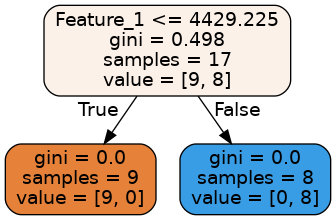

In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
from IPython.display import Image


# Obtenir les noms de caractéristiques après le prétraitement
transformed_feature_names = (model.named_steps['columntransformer']
                                  .named_transformers_['onehotencoder']
                                  .get_feature_names_out(input_features=['Departement', 'Sexe', 'Nom', 'Prenom']))

# Ajouter les noms des autres caractéristiques qui n'ont pas été transformées
other_features = [f'Feature_{i}' for i in range(df.shape[1] - 5)]
transformed_feature_names = list(transformed_feature_names) + other_features

# Passer "transformed_feature_names" à "export_graphviz" à la place de "feature_names"
export_graphviz(
    model.named_steps['decisiontreeclassifier'],
    out_file="election.dot",
    feature_names=transformed_feature_names,
    rounded=True,
    filled=True
)

#appel à la fonction dot de graphwiz
os.system("dot -Tpng election.dot -o election.png")
#Affichage de l'image créée
Image("election.png")